In [37]:
using LinearAlgebra, NBInclude, IterativeSolvers, FunctionOperators, Printf, Plots, LaTeXStrings

‚îå Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
‚îî @ Base loading.jl:1278


In [3]:
@nbinclude("helper_functions.ipynb")

‚îå Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
‚îî @ Base loading.jl:1278
‚îå Info: Precompiling ToeplitzMatrices [c751599d-da0a-543b-9d20-d0a503d91d24]
‚îî @ Base loading.jl:1278


rand (generic function with 167 methods)

In [4]:
Random.seed!(123);

### Vanilla MatrixIRLS for matrix completion (PCA) with p = 0

https://mediatum.ub.tum.de/doc/1521436/1521436.pdf

_**Note:** Vanilla = Conjugate gradient step (2.90) is solved directly without reducing the problem to a lower-dimensional projection space._

<span style="color:red"><strong>Problem:</strong> I don't know how should I calculate the solution of the constrained problem of arg $min_x \langle X,W^{k-1}(X)\rangle \text{ s.t. } \Phi(X) = y$ with conjugate gradient.</span>

**Possible solutions:**
- **[Linearly Constrained Least Squares](https://lls.readthedocs.io/en/latest/math.html):** In our case, $$min_x \Vert W^{1/2} x - b \Vert_2 \text{ s.t. } \Phi x = y$$ can be solved as $$\begin{bmatrix} 2 W^{1/2 *} W^{1/2} & \Phi^*\\ \Phi & 0 \end{bmatrix} \begin{bmatrix} x \\ z \end{bmatrix} = \begin{bmatrix} 2 W^{1/2} b \\ y \end{bmatrix},$$ where $z$ is a new variable. This system has a unique solution when the matrix $\Phi$ has independent rows (this is always true for sampling matrices), and the matrix $\begin{bmatrix} A \\ C \end{bmatrix}$ has indepedent columns (I'm not sure if it is always true).
  - *The problem with this approach:*
      - *I don't know how to calculate $W^{1/2}$ because it is not a matrix, but rather a function (see 2.57 on page 73).*
      - *This method requires x to be a vector and $W$ should also be modified accordingly. Again, as $W$ is not a matrix, I have no idea how can I transform $W$ to suit the vectorized problem.*
      - *$b$ is unknown.*
      - *[The only Julia package](https://github.com/davidlizeng/LinearLeastSquares.jl) I found that solves the problem in this way is really outdated, and accepts only matrices.*
- **Augmented Lagrangian and ADMM**
  - *The problem with this approach:*
      - *All of the solvers require $x$ to be a vector and $W$ should also be modified accordingly, but I don't know how it should be done.*
      - *The solvers I found either support multi-variable (i.e. matrix) optimization or deal with general matrix-like/function-like objects like $W$, but I couldn't find any which does both.*

In [5]:
function vanilla_MatrixIRLS_for_PCA(
        X·¥≥·µÄ::AbstractArray,                     # ground truth for MSE evaluation
        y::AbstractArray,                       # under-sampled data
        Œ¶::FunctionOperator;                    # sampling operator
        img_size::NTuple = size(X·¥≥·µÄ),           # size of output matrix
        rÃÉ::Int = 0,                             # rank estimate of solution
        maxIter::Union{Int, Nothing} = nothing, # number of CG iteration steps
        N::Int = 10,                            # number of iterations
        verbose::Bool = false)                  # print rank and loss value in each iteration
    
    # Initialize variables
    dType = eltype(y)
    d‚ÇÅ, d‚ÇÇ = img_size
    rÃÉ == 0 && (rÃÉ = rank(X·¥≥·µÄ))
    maxIter = maxIter isa Nothing ? rÃÉ*(rÃÉ+d‚ÇÅ+d‚ÇÇ) : maxIter
    œµ·µè = Inf
    X·µè = Œ¶' * y
    œÉ = nothing # I just want to make it available outside of the loop
    
    for k in 1:N
"""
    2. Find best rank-(rÃÉ + 1) approximation of X·µè to obtain
        ùíØ·µ£(X·µè) = U·µè * diag(œÉ·µ¢·µè)·µ¢‚Çå‚ÇÅ ≥ * V·µè' and œÉ·µ£‚Çä‚ÇÅ·µè 
"""
        F = svd(X·µè)
        U·µè, œÉ, V·µè = F.U[:, 1:rÃÉ], F.S, F.V[:, 1:rÃÉ]
        
"""     update smoothing:                                 (2.91) """
        œµ·µè = min(œµ·µè, œÉ[rÃÉ+1])
        
        r, n, s, e = rank(X·µè, atol = 1e-3), opnorm(X·¥≥·µÄ - X·µè, 2), œÉ[1], œµ·µè
        n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
        verbose && println("k = $(k-1),\trank(X·µè) = $r,\t‚ÄñX·¥≥·µÄ - X·µè‚Äñ‚ÇÇ = $n, œÉ‚ÇÅ = $s, œµ·µè = $e")
        
"""
    3. Update W·µè as in (2.57), using parameters œµ = œµ·µè and p in (2.58) and (2.59), and the
        information U·µè , V·µè and œÉ‚ÇÅ·µè, ..., œÉ·µ£‚Çä‚ÇÅ·µè from item 2.

        (Lines below are based on Remark 2.3.2, the special case for p = 0)
"""
        H·µè = [1 / (max(œÉ[i], œµ·µè) * max(œÉ[j], œµ·µè))  for i in 1:rÃÉ+1, j in 1:rÃÉ+1]
        W·µè = FunctionOperator{dType}(name = "W·µè", inDims = (d‚ÇÅ, d‚ÇÇ), outDims = (d‚ÇÅ, d‚ÇÇ),
            forw = Z -> U·µè * (H·µè .* (U·µè' * Z * V·µè)) * V·µè')
        
"""
    1. Use a conjugate gradient method to solve linearly constrained quadratic program
         X·µè = arg min‚Çì ‚ü®X,W·µè‚Åª¬π(X)‚ü© s.t. Œ¶(X) = y         (2.90)
"""
        CG_op = throw(ErrorException("How should I calculate the solution of the constrained problem of " *
                                    "arg min‚Çì ‚ü®X,W·µè‚Åª¬π(X)‚ü© s.t. Œ¶(X) = y with conjugate gradient?"))
        X·µè = cg(CG_op, b, maxiter = maxIter)
    end
    
    r, n, s, e = rank(X·µè, atol = 1e-3), opnorm(X·¥≥·µÄ - X·µè, 2), œÉ[1], œµ·µè
    n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
    verbose && println("k = $N,\trank(X·µè) = $r,\t‚ÄñX·¥≥·µÄ - X·µè‚Äñ‚ÇÇ = $n, œÉ‚ÇÅ = $s, œµ·µè = $e")
    
    X·µè
end

vanilla_MatrixIRLS_for_PCA (generic function with 1 method)

A slightly different formulation from the draft "Robust PCA by Iteratively Reweighted Least Squares". In the implementation below I followed the instructions from the draft and took the special case when the sparse component is zero.

In [20]:
function vanilla_MatrixIRLS_for_PCA_with_CG(
        X·¥≥·µÄ::AbstractArray,                     # ground truth for MSE evaluation
        y::AbstractArray,                       # under-sampled data
        Œ¶::FunctionOperator;                    # sampling operator
        img_size::NTuple = size(X·¥≥·µÄ),           # size of output matrix
        rÃÉ::Int = 0,                             # rank estimate of solution
        Œª::Real,
        maxIter::Union{Int, Nothing} = nothing, # number of CG iteration steps
        N::Int = 10,                            # number of iterations
        verbose::Bool = false)                  # print rank and loss value in each iteration
    
    # Initialize variables
    dType = eltype(y)
    d‚ÇÅ, d‚ÇÇ = img_size
    rÃÉ == 0 && (rÃÉ = rank(X·¥≥·µÄ))
    maxIter = (maxIter isa Nothing ? rÃÉ*(rÃÉ+d‚ÇÅ+d‚ÇÇ) : maxIter)
    œµ = Inf
    X‚ÇÄ = Œ¶' * y   # that's basically P·µÉ * P(M) as y = P(M)
    X = copy(X‚ÇÄ)
    Œ¶·µÉŒ¶ = Œ¶' * Œ¶  # i.e. P·µÉ_Omega * P_Omega
    W = I
    
    r, n, s, e = rank(X, atol = 1e-3), norm(X·¥≥·µÄ - X), svdvals(X)[1], œµ
    n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
    verbose && println("k = 0,\trank(X) = $r,\t‚ÄñX·¥≥·µÄ - X‚Äñ‚ÇÇ = $n,\tœÉ‚ÇÅ = $s,\tœµ = $e")
    
    for k in 1:N

        # I don't know how to calculate inverses in (29), so I use the equation right after it:
        # ((Œª/Œº * W‚Çõ + P' * P) * W‚Çó + Œª * W‚Çõ * P' * P)(L) = Œª * W‚Çõ * P' * P(M)
        # Assuming that Œº = ‚àû and W‚Çõ = I, that's what I get:
        A = Œ¶·µÉŒ¶ * W + Œª * Œ¶·µÉŒ¶
        b = Œª * X‚ÇÄ
        cg!(vec(X), reshape(A, inDims=(d‚ÇÅ*d‚ÇÇ,), outDims=(d‚ÇÅ*d‚ÇÇ,)), vec(b),
            tol=1e-8) # Solve A‚ãÖX = b for X
        
        F = svd(X)
        U, œÉ, V = F.U, F.S, F.V
        
        œµ = min(œµ, œÉ[rÃÉ+1])
        
        d = min(d‚ÇÅ, d‚ÇÇ)
        H = [1 / (max(œÉ[i], œµ) * max(œÉ[j], œµ))  for i in 1:d, j in 1:d]
        W = FunctionOperator{dType}(name = "W", inDims = (d‚ÇÅ, d‚ÇÇ), outDims = (d‚ÇÅ, d‚ÇÇ),
            forw = Z -> convert.(dType, U * (H .* (U' * Z * V)) * V'))
        
        r, n, s, e = rank(X, atol = 1e-3), norm(X·¥≥·µÄ - X), œÉ[1], œµ
        n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
        verbose && println("k = $k,\trank(X) = $r,\t‚ÄñX·¥≥·µÄ - X‚Äñ‚ÇÇ = $n,\tœÉ‚ÇÅ = $s,\tœµ = $e")
        
        # exit loop if it is pointless to continue
        œµ > 1e-4 || œÉ[1] > 1e-4 || r != 0 || break
        
    end
    
    X, rank(X, atol = 1e-3), norm(X·¥≥·µÄ - X), svdvals(X)[1], œµ
end

vanilla_MatrixIRLS_for_PCA_with_CG (generic function with 1 method)

# Numerical Experiments

### General parameters

In [7]:
# Matrix dimensions
d‚ÇÅ, d‚ÇÇ = 50, 50
n = min(d‚ÇÅ, d‚ÇÇ)
# Rank and number of non-zero elements in sparse component
r, k = 7, 0
# Type of matrix elements
dType = ComplexF64;

## Understanding and Enhancing Data Recovery Algorithms

*From Noise-Blind Sparse Recovery to Reweighted Methods for Low-Rank Matrix Optimization*

*by Christian K√ºmmerle*

https://mediatum.ub.tum.de/doc/1521436/1521436.pdf

### Generate Data

#### Gaussian Low Rank Matrix
Corresponding Matlab function: https://github.com/ckuemmerle/hm_irls/blob/master/sample_X0_lowrank.m

In [8]:
L‚ÇÄ = generateLowRankComponent_Christian(d‚ÇÅ, d‚ÇÇ, r, dType)
@show size(L‚ÇÄ)
@show rank(L‚ÇÄ);

size(L‚ÇÄ) = (50, 50)
rank(L‚ÇÄ) = 7


#### Sampling Mask ($\Phi$)
Corresponding Matlab function: https://github.com/ckuemmerle/hm_irls/blob/master/sample_phi_MatrixCompletion.m

_**Note:** There is a difference in the way how the Christian's Matlab function and my Julia function satisfies the requirement of having at least $r$ non-zero entries in each row and each column._

In [9]:
df = r * (d‚ÇÅ + d‚ÇÇ - r) # Number of degrees of freedom of the setting
m = floor(Int, min(1.05 * df, d‚ÇÅ * d‚ÇÇ))
Œ¶·¥π = generateŒ¶(d‚ÇÅ, d‚ÇÇ, r, m)
Œ¶ = FunctionOperator{dType}(name = "Œ¶", inDims = (d‚ÇÅ, d‚ÇÇ), outDims = (d‚ÇÅ, d‚ÇÇ),
    forw = (b,x) -> b .= Œ¶·¥π .* x, backw = (b,x) -> b .= x)
@show r
println("minimum number of non-zero entries in each column: ", Int(minimum(sum(Œ¶·¥π, dims=1))))
println("minimum number of non-zero entries in each column: ", Int(minimum(sum(Œ¶·¥π, dims=2))))

r = 7
minimum number of non-zero entries in each column: 9
minimum number of non-zero entries in each column: 8


#### Subsampling The Ground Truth Matrix

In [10]:
y = Œ¶ * L‚ÇÄ
@show rank(y);

rank(y) = 50


### Running The Reconstruction

In [45]:
Œªs = 0.018:0.001:0.030
results = [vanilla_MatrixIRLS_for_PCA_with_CG(L‚ÇÄ, y, Œ¶, Œª=Œª, N = 70) for Œª in Œªs];

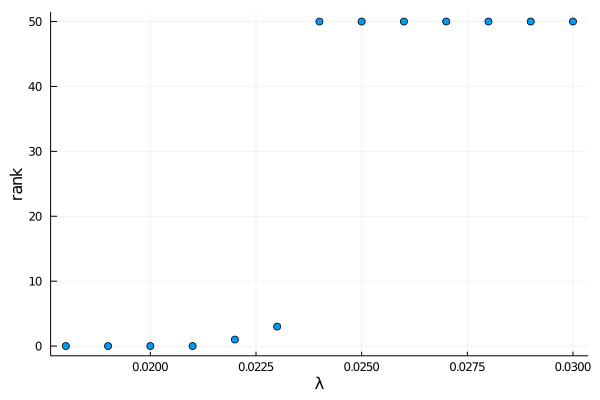

In [46]:
ranks = [t[2] for t in results]
plot(Œªs, ranks, seriestype = :scatter, xlabel = "Œª", ylabel = "rank", legend = false)

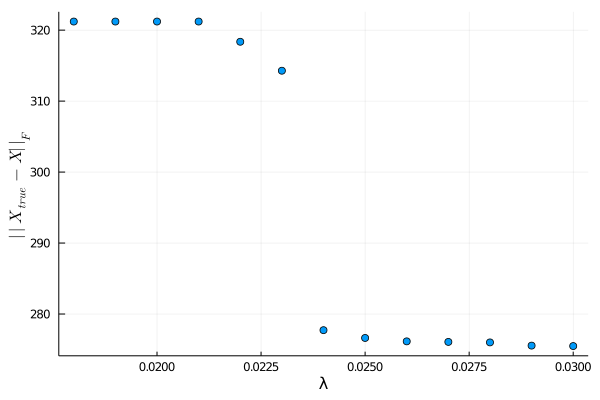

In [47]:
error = [t[3] for t in results]
plot(Œªs, error, seriestype = :scatter, xlabel = "Œª", ylabel = L"||X_{true} - X||_F", legend = false)

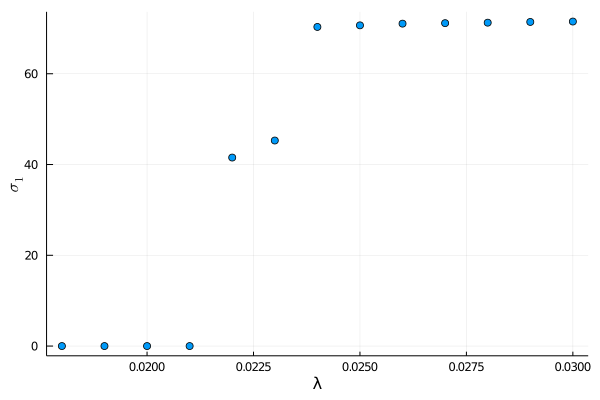

In [48]:
œÉs = [t[4] for t in results]
plot(Œªs, œÉs, seriestype = :scatter, xlabel = "Œª", ylabel = L"\sigma_1", legend = false)

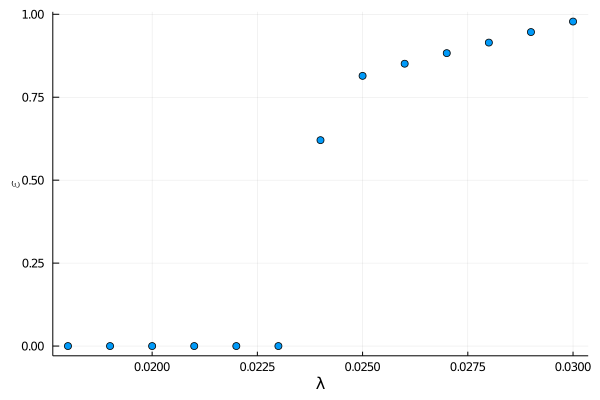

In [49]:
œµs = [t[5] for t in results]
plot(Œªs, œµs, seriestype = :scatter, xlabel = "Œª", ylabel = L"\epsilon", legend = false)

In [50]:
Œªs = 0.022:0.0001:0.024
results = [vanilla_MatrixIRLS_for_PCA_with_CG(L‚ÇÄ, y, Œ¶, Œª=Œª, N = 100) for Œª in Œªs];

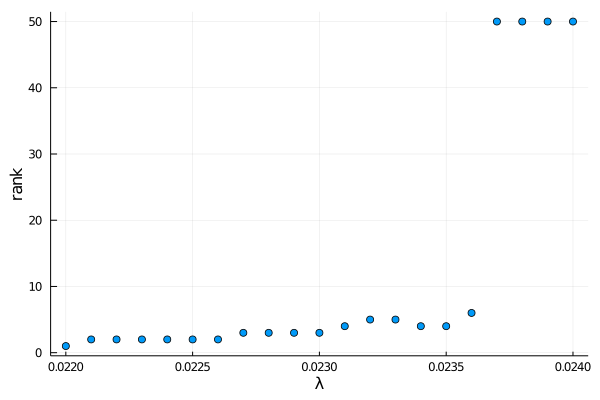

In [51]:
ranks = [t[2] for t in results]
plot(Œªs, ranks, seriestype = :scatter, xlabel = "Œª", ylabel = "rank", legend = false)

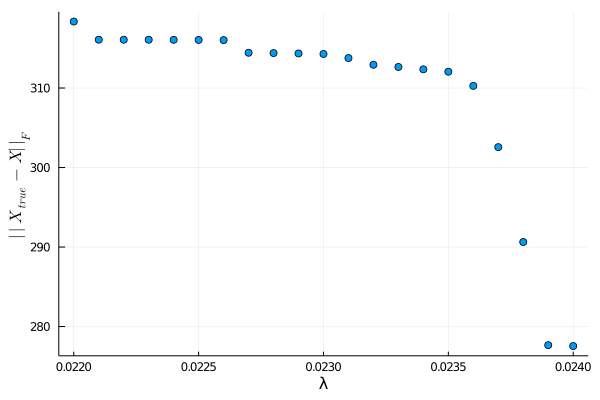

In [52]:
error = [t[3] for t in results]
plot(Œªs, error, seriestype = :scatter, xlabel = "Œª", ylabel = L"||X_{true} - X||_F", legend = false)

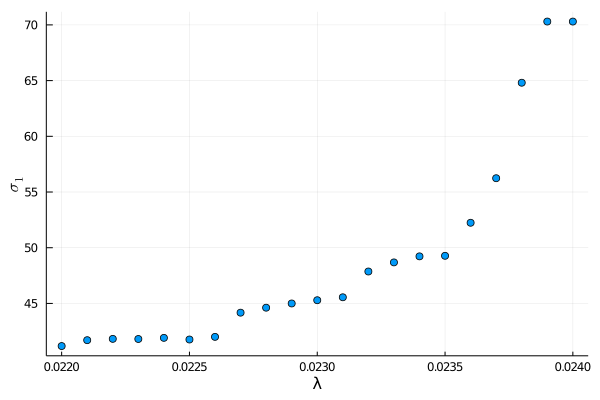

In [53]:
œÉs = [t[4] for t in results]
plot(Œªs, œÉs, seriestype = :scatter, xlabel = "Œª", ylabel = L"\sigma_1", legend = false)

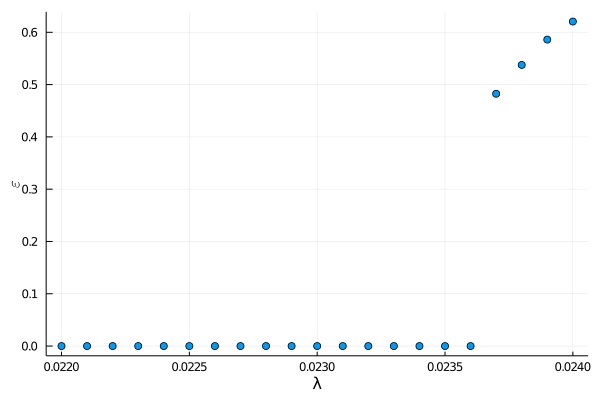

In [54]:
œµs = [t[5] for t in results]
plot(Œªs, œµs, seriestype = :scatter, xlabel = "Œª", ylabel = L"\epsilon", legend = false)

# Robust Principal Component Analysis?
*by Emmanuel J. Cand√®s, Xiaodong Li, Yi Ma, and John Wright*  
https://arxiv.org/pdf/0912.3599.pdf

#### 4.1 Exact recovery from varying fractions of error

We first verify the correct recovery phenomenon of Theorem 1.1 on randomly generated problems. We consider square matrices of varying dimension $n = 500, \ldots , 3000$. We generate a rank-$r$ matrix $L_0$ as a product $L_0 = XY^‚àó$ where $X$ and $Y$ are $n \times r$ matrices with entries independently sampled
from a $\mathcal{N}(0,1/n)$ distribution. $S_0$ is generated by choosing a support set $\Omega$ of size $k$ uniformly at random, and setting $S_0 = \mathcal{P}_\Omega E$, where $E$ is a matrix with independent Bernoulli $\pm 1$ entries. Table 1 (top) reports the results with $r = rank(L_0) = 0.05 \times n$ and $k = \Vert S_0 \Vert_0 = 0.05 \times n^2$. Table 1 (bottom) reports the results for a more challenging scenario, $rank(L_0) = 0.05 \times n$ and $k = 0.10 \times n^2$. In all cases, we set $\lambda = 1 \cdot \sqrt{n}$. Notice that in all cases, solving the convex PCP gives a result $(L, S)$ with the correct rank and sparsity. Moreover, the relative error $\frac{\Vert L - L_0 \Vert_F}{\Vert L_0 \Vert_F}$ is small, less than $10^{-5}$ in all examples considered.

<center><img src="table_1.png" /></center>

### Generate Data

_**Note:** In this notebook we deal only with PCA (simple matrix completion); therefore, there is no sparse component in the ground truth matrix._

In [10]:
L‚ÇÄ = generateLowRankComponent_Candes(n, r, dType)
@show size(L‚ÇÄ)
@show rank(L‚ÇÄ);

size(L‚ÇÄ) = (50, 50)
rank(L‚ÇÄ) = 7


#### Sampling Mask ($\Phi$)

Using the earlier generated sampling mask

#### Subsampling The Ground Truth Matrix

In [11]:
y = Œ¶ * L‚ÇÄ
@show rank(y);

rank(y) = 50


### Running The Reconstruction

In [12]:
@time vanilla_MatrixIRLS_for_PCA(L‚ÇÄ, y, Œ¶, N = 80, verbose = true);

k = 0,	rank(X·µè) = 44,	‚ÄñX·¥≥·µÄ - X·µè‚Äñ‚ÇÇ =   0.044, œÉ‚ÇÅ =   0.020, œµ·µè =   0.011


LoadError: How should I calculate the solution of the constrained problem of arg min‚Çì ‚ü®X,W·µè‚Åª¬π(X)‚ü© s.t. Œ¶(X) = y with conjugate gradient?